# Bayesian Data Analysis 2019 - Data Analysis Project Report

## Loaded packages

Below are the loaded packages that are used in the project. Remember to make sure that all the packages are installed into the system (for example, pystan).

In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import pystan

## Description of data

The data set used is provided by UCI Machine Learning Repository.

The data set is called "Metro Interstate Traffic Volume Data Set", and it is described by the provider as follows: "Hourly Interstate 94 Westbound traffic volume for MN DoT ATR station 301, roughly midway between Minneapolis and St Paul, MN. Hourly weather features and holidays included for impacts on traffic volume."

Below we load the data from our csv file. This file is accessible at https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume 

We also take the first look at the data

In [2]:
# load data

df = pd.read_csv("Metro_Interstate_Traffic_Volume.csv")

df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [3]:
#df.describe()

There are many labelled data columns in our data. Below we can see the holiday, weather main and weather description labels.

In [4]:
#df['holiday'].value_counts()

In [5]:
#df['weather_main'].value_counts()

In [6]:
#df['weather_description'].value_counts()

Let's look at the data that we have in quantified form. First the traffic volume. This data seems good. There are no clear outliers.

Text(0.5, 1.0, 'Traffic volume')

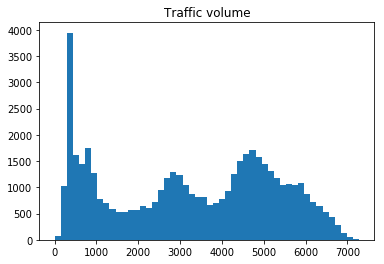

In [22]:
plt.hist(df['traffic_volume'], bins=50)
plt.title("Traffic volume")

From the temperature data we can see that there are clear outliers. The x-axel is scaled from 0 to 300 even though there are barely any values below 250. When we dig deeper below the 250 values, we can see there are a couple of really low values. 

In [8]:
#plt.hist(df['temp'], bins=50)
#plt.title("Temperature")

In [9]:
#df_low_temp = df[df['temp'] < 250]
#plt.hist(df_low_temp['temp'], bins=50)
#plt.title("Low temperatures")

In [10]:
#df[df['temp'] == 0]

When we look at these zero Kelvin temperatures, we can see that the observations seem otherwise correct. The sky is clear, there is no rain or snow, and there are some small amounts of traffic during that time. Thus, we suggest that these datapoints only lack the temperature data and can still be used. We will fix the points by taking the average temperature during similar times (Jan-Feb nights).

Next off is the rain. We can see again that there are some outliers. When we take the description of our data, we see there is a datapoint with around 9831 mm of rain. Otherwise, the data seems reasonable. There are some 50mm rain points, but this is still realistic within one hour of really heavy rain. We will set the 9831mm datapoint to an average of our very heavy rain weather descriptions

In [11]:
#plt.hist(df['rain_1h'], bins=50)
#plt.title("Rain")

In [12]:
#df[df['weather_description'] == 'very heavy rain']

In [13]:
#df_rain = df[df['rain_1h'] < 9831]
#plt.hist(df_rain['rain_1h'], bins=50)
#plt.title("Corrected rain")

With snow and clouds, the data seems to be correct. There are a lot of datapoints with 0 snow, but there are also a lot of points where there are similar looking numbers of snow. With clouds, the data is quite dispersed.

In [14]:
#plt.hist(df['snow_1h'], bins=150)
#plt.title("Snow")

In [15]:
#plt.hist(df['clouds_all'], bins=50)
#plt.title("Clouds")

In [27]:
# daytime-specific traffic data:
import datetime

# convert date_time-field into datetime format & add index
df_with_dates = df
df_with_dates['date_time'] = pd.to_datetime(df['date_time'], format='%Y-%m-%d %H:%M:%S')
df_with_dates = df_with_dates.set_index('date_time')
df_with_dates['weekday'] = df_with_dates.index.dayofweek
df_with_dates['month'] = df_with_dates.index.month
df_with_dates.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,weekday,month
date_time,,,,,,,,,,
2012-10-02 09:00:00,None,288.28,0.0,0.0,40,Clouds,scattered clouds,5545,1,10
2012-10-02 10:00:00,None,289.36,0.0,0.0,75,Clouds,broken clouds,4516,1,10
2012-10-02 11:00:00,None,289.58,0.0,0.0,90,Clouds,overcast clouds,4767,1,10
2012-10-02 12:00:00,None,290.13,0.0,0.0,90,Clouds,overcast clouds,5026,1,10
2012-10-02 13:00:00,None,291.14,0.0,0.0,75,Clouds,broken clouds,4918,1,10


Text(0.5, 1.0, 'Traffic at 12:00')

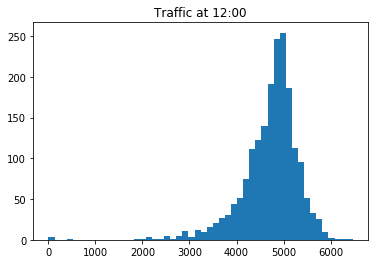

In [50]:
def traffic_at_time(time):
    return df_with_dates.at_time('{}:00'.format(time))['traffic_volume']

# inefficient, but makes testing easier
traffic_by_time = [traffic_at_time(time) for time in range(24)]

# make all sublists same size
min_n = min([len(traffic_by_time[n]) for n in range(24)])
traffic_by_time = [traffic_by_time[n][:min_n] for n in range(24)]

# e.g. traffic volume at 12

plt.hist(traffic_by_time[12], bins=50)
plt.title("Traffic at 12:00")

## Description of data analysis problem

Based on the visualizations of the traffic data, we find that there are multiple peaks in traffic volume. Our hypothesis is that the total traffic volume at any given time is largely dictated by the time of day.

Thus, our data analysis problem is to analyze the differences in traffic caused by the time of the day.

## Description of models

For the data analysis problem, we chose to use hierarchical and pooled models.

latex:

In Markdown, equations can easily be formulated using LaTeX in line as $f(k) = {n \choose k} p^{k} (1-p)^{n-k}$ or use the math environment as follows:

$$\begin{array}{ccc}
x_{11} & x_{12} & x_{13}\\
x_{21} & x_{22} & x_{23}
\end{array}$$


### Hierarchical model

// kuvailua

### Pooled model // onks täl joku täsmällisempi nimi?

// lisää kuvailua

## Prior choices

// priorivalintojen perusteleminen tässä

Informative vai weakly informative?

Perustuu luultavasti aikasempaan visuaaliseen tulkintaan noista jakaumista


## The model and training

Next off we are going to introduce our model and train it using STAN.

This model is a modified version of "Comparison of k groups with common variance (ANOVA)" accessed on 06/12/19 from http://avehtari.github.io/BDA_R_demos/demos_rstan/rstan_demo.html#8_comparison_of_k_groups_with_hierarchical_models

In [19]:
pooled_model = """
data {
    int<lower=0> N;
    vector[N] y;
}
    parameters {
    real mu;
    real<lower=0> sigma;
}
model {
    y ~ normal(mu, sigma);
}
generated quantities {
    real ypred;
    vector[N] log_lik;
    ypred = normal_rng(mu, sigma);
    for (i in 1:N)
        log_lik[i] = normal_lpdf(y[i] | mu, sigma);
}

"""

In [20]:
pooled_stan = pystan.StanModel(model_code=pooled_model)

flattened_factory_data = traffic_by_time[9]

pooled_data= {
    "N": len(flattened_factory_data),
    "y": flattened_factory_data
}

pooled_fit = pooled_stan.sampling(data=pooled_data)

pooled_samples = pooled_fit.extract(permuted=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_38e49d0b14fc415bc533c17a1e9150d1 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


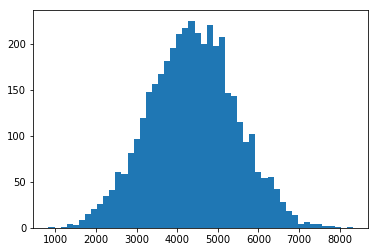

In [21]:
plt.hist(pooled_samples['ypred'], bins=50);